In [65]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [66]:
# using sqlite table to read data

con1 = sqlite3.connect("database.sqlite")

filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3 LIMIT 30000""", con1)

def polarity(x):
    
    if x<3:
        return "negetive"
    else:
        return "positive"
    
# applying polarity function on filtered_data

filtered_data["Score"] = filtered_data["Score"].map(polarity)
print(filtered_data.shape)
filtered_data.head(3)

(30000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negetive,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [67]:
# sorting data in ascending order
sorted_data = filtered_data.sort_values("ProductId", axis = 0, ascending = True, inplace = False, kind = "quicksort", \
                                        na_position = "last")

# Deduplication of entries
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep="first",inplace=False)

print(final.shape)

((final.shape[0]*1.0)/(filtered_data.shape[0]*1.0)*100)


(28072, 10)


93.57333333333332

In [68]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
print(final.shape)

(28072, 10)


## Text Preprocessing 

In [69]:
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))
words_to_keep = set(("not"))

# initialise snowball stemmer
sno = nltk.stem.SnowballStemmer("english")

# function to clean wdef cleanhtml(sentence):
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

# #function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [70]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [71]:
# adding a column cleanedtext which contains the data after preprocessing reviews

final["CleanedText"] = final_string
final["CleanedText"] = final["CleanedText"].str.decode("utf-8")
print(final.shape)

(28072, 11)


## Time based splitting in train and test data

In [72]:
from sklearn.model_selection import train_test_split

time_sorted_data = final.sort_values("Time", axis=0, ascending = True, inplace = False, kind="quicksort", na_position = "last")

x = time_sorted_data["CleanedText"].values
y = time_sorted_data["Score"]

# train and test splitting
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(19650,)
(19650,)
(8422,)
(8422,)


## BoW

In [73]:
count_vect = CountVectorizer(min_df=100)
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)

print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (19650, 1046)
the number of unique words : 1046


In [74]:
import warnings
warnings.filterwarnings("ignore")

# standardization of data

from sklearn.preprocessing import StandardScaler

sc = StandardScaler(with_mean= False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)


## GridSearchCV Implementation (SVC with Hinge Loss)

In [75]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

Alpha = [0.001, 0.01, 0.1, 1, 10]

param_grid = {"alpha":Alpha}
 # SGDCLassifier() --> default = hinge-loss
model = GridSearchCV (SGDClassifier() , param_grid , scoring = "accuracy", cv=3 , n_jobs = -1 , pre_dispatch = 2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

Model with best parameters :
 SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.902279743528853


In [76]:
optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha is :", optimal_alpha)

The optimal value of alpha is : 0.1


In [77]:
# SGDClassifier with optimal value of alpha

sgd = SGDClassifier(alpha = optimal_alpha , n_jobs = -1)
sgd.fit(X_train_vec_standardized, Y_train)
predictions = sgd.predict(X_test_vec_standardized)

In [78]:
# Variables that will be used for  making table in Conclusion part of this assignment
bow_grid_alpha = optimal_alpha
bow_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_grid_test_acc = accuracy_score(Y_test, predictions) * 100

In [79]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the SGDClassifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))


The Test Accuracy of the SGDClassifier for alpha = 0.100 is 90.216101%

The Test Precision of the SGDClassifier for alpha = 0.100 is 0.916098

The Test Recall of the SGDClassifier for alpha = 0.100 is 0.972029

The Test F1-Score of the SGDClassifier for alpha = 0.100 is 0.943235


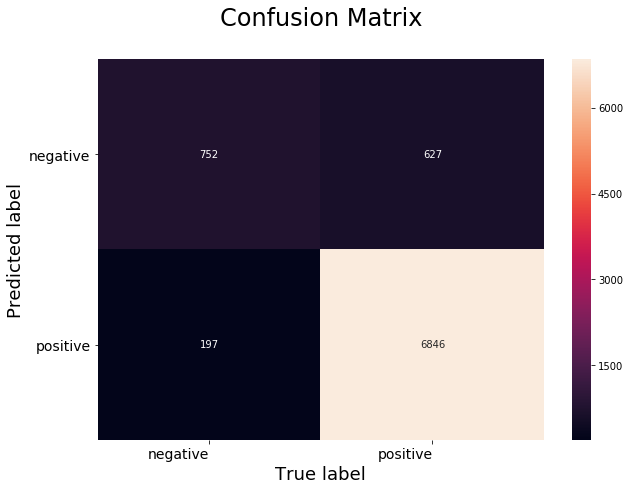

In [80]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

## TF-IDF

In [81]:
tf_idf_vect = TfidfVectorizer(min_df=100)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (19650, 1046)
the number of unique words : 1046


In [82]:
Alpha = [0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

# SGDClassifier with Optimal value of alpha i.e.(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_grid_alpha = optimal_alpha
tfidf_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9007361671811921
The optimal value of alpha(1/C) is :  0.1


In [83]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the SGDClassifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))


The Test Accuracy of the SGDClassifier for alpha = 0.100 is 89.990501%

The Test Precision of the SGDClassifier for alpha = 0.100 is 0.910487

The Test Recall of the SGDClassifier for alpha = 0.100 is 0.976289

The Test F1-Score of the SGDClassifier for alpha = 0.100 is 0.942240


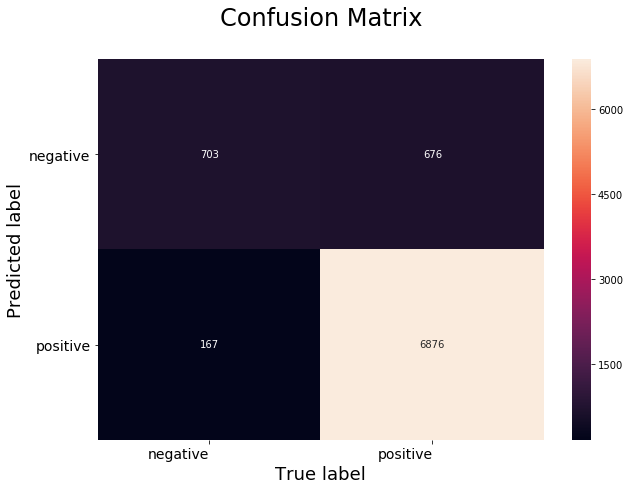

In [84]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()



## Word2Vec

In [85]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  5929


## Avg Word2Vec

In [86]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec) 

# Data-preprocessing: Standardizing the data
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(train_vectors)
X_test_vec_standardized = sc.transform(test_vectors)

In [87]:
Alpha = [0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

# SGDClassifier with Optimal value of alpha i.e.(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_grid_alpha = optimal_alpha
avg_w2v_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.8647589646164806
The optimal value of alpha(1/C) is :  0.01


In [88]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the SGDClassifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))


The Test Accuracy of the SGDClassifier for alpha = 0.010 is 86.760864%

The Test Precision of the SGDClassifier for alpha = 0.010 is 0.874432

The Test Recall of the SGDClassifier for alpha = 0.010 is 0.982820

The Test F1-Score of the SGDClassifier for alpha = 0.010 is 0.925463


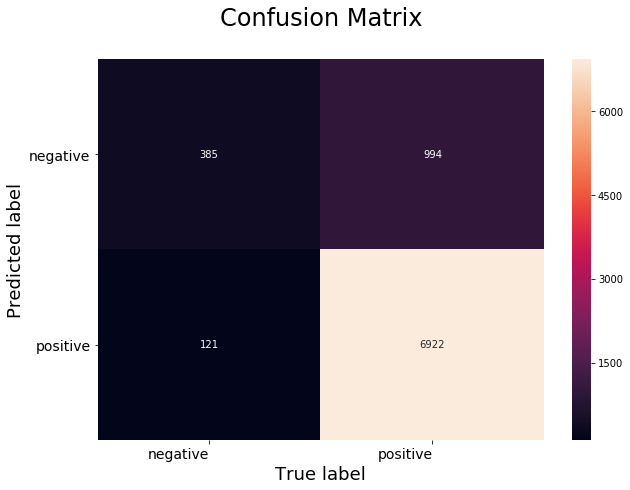

In [89]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

## TFIDF-Word2Vec

In [90]:
my_final = time_sorted_data.take(np.random.permutation(len(final)))
print(my_final.shape)

x = my_final['CleanedText'].values
y = my_final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split()) 
    
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)

(28072, 11)


In [91]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in sent_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1

In [92]:
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in sent_of_train: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  
    
# Data-preprocessing: Standardizing the data
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(tfidf_train_vectors)
X_test_vec_standardized = sc.transform(tfidf_test_vectors)

In [93]:
Alpha = [0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

# SGDClassifier with Optimal value of alpha i.e.(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_grid_alpha = optimal_alpha
tfidf_w2v_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2v_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.7884113037283306
The optimal value of alpha(1/C) is :  0.01


In [94]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the SGDClassifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))


The Test Accuracy of the SGDClassifier for alpha = 0.010 is 78.033721%

The Test Precision of the SGDClassifier for alpha = 0.010 is 0.864374

The Test Recall of the SGDClassifier for alpha = 0.010 is 0.879127

The Test F1-Score of the SGDClassifier for alpha = 0.010 is 0.871688


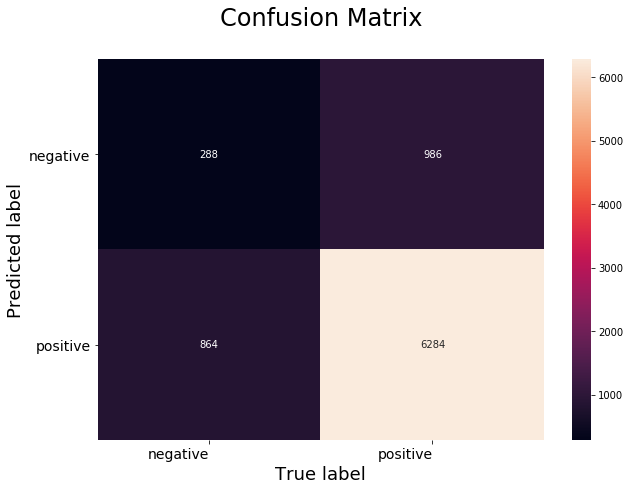

In [95]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [96]:
my_final = time_sorted_data.take(np.random.permutation(len(final)))
print(my_final.shape)

x = my_final['CleanedText'].values
y = my_final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

#BoW (Bag of Words Vectorizer)
count_vect = CountVectorizer(min_df = 100) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)


(28072, 11)
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (19650, 1040)
the number of unique words : 1040


In [97]:
Alpha = [0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

# SGDClassifier with Optimal value of alpha i.e.(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
predictions = sgd.predict(X_test_vec_standardized)

Model with best parameters :
 SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.904298266445025
The optimal value of alpha(1/C) is :  0.1


In [98]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the SGDClassifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))


The Test Accuracy of the SGDClassifier for alpha = 0.100 is 90.441700%

The Test Precision of the SGDClassifier for alpha = 0.100 is 0.918140

The Test Recall of the SGDClassifier for alpha = 0.100 is 0.973373

The Test F1-Score of the SGDClassifier for alpha = 0.100 is 0.944950


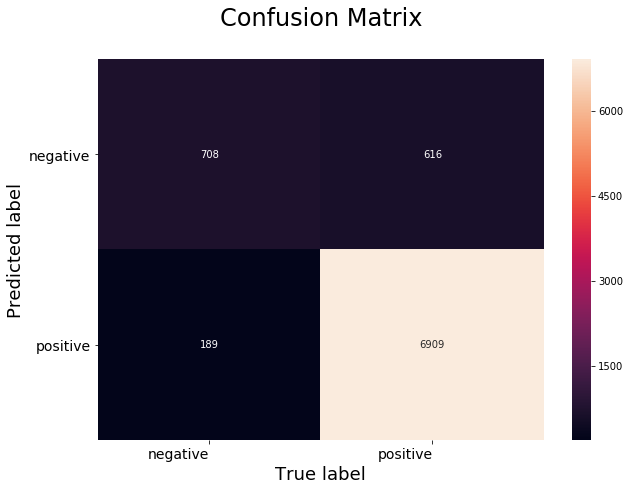

In [99]:
 #Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

## SVC with RBF Kernel

In [100]:
from sklearn.svm import SVC

C_range = [1,2,4,8,16,32]

param_grid = {'C': C_range}
model = GridSearchCV(SVC(), param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C is : ",optimal_C)

# SVC with RBF kernel with Optimal value of C
svc = SVC(C=optimal_C)
svc.fit(X_train_vec_standardized,Y_train)
predictions = svc.predict(X_test_vec_standardized)

Model with best parameters :
 SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of the model :  0.9012111137497032
The optimal value of C is :  2


In [101]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of SVC with RBF kernel for C = %d is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of SVC with RBF kernel for C = %d is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of SVC with RBF kernel for C = %d is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of SVC with RBF kernel for C = %d is %f' % (optimal_C, acc))


The Test Accuracy of SVC with RBF kernel for C = 2 is 90.121111%

The Test Precision of SVC with RBF kernel for C = 2 is 0.910401

The Test Recall of SVC with RBF kernel for C = 2 is 0.979149

The Test F1-Score of SVC with RBF kernel for C = 2 is 0.943524


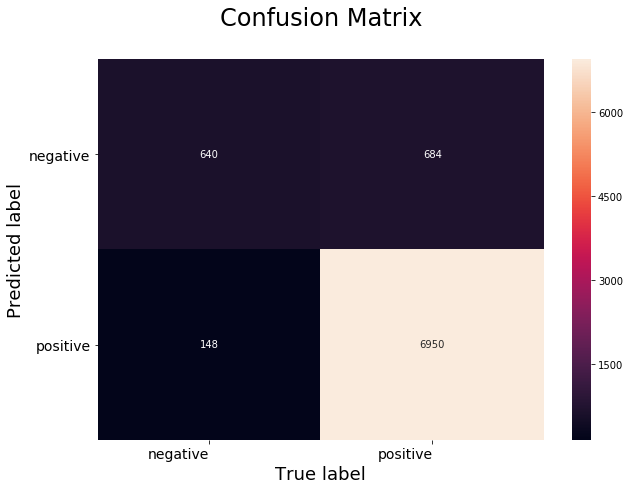

In [102]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()